# Tutorial: Introduction to variational calculations. 

## Finding ground states.

Authors: Javier Robledo Moreno, Filippo Vicentini

This notebook is based on some classes given by Javier Moreno and Giuseppe Carleo at Flatiron Institute in 2022. It has been adapted for this website a while later by Filippo Vicentini.

**This notebook is more about an introduction to Variational methods and Stochastic Reconfiguration than a real introduction to NetKet. If you are already familiar with those methods and just want to learn about NetKet, check out the Ising ground-state tutorial!**

The notebook starts with a refresher on some concepts from Quantum Mechanics in section 1, but if you are a physicist and already familiar with those ideas we encourage you to skip right to section 2.

## 0. Dependencies 

To run this tutorial, you will need to install [NetKet](https://www.netket.org/) and some other dependencies.
You can do so by removing the leading `#` in the following cell and running it.

The cell is commented by default such that if you have already installed all dependencies in your computer, it does not run by default all the time

In [1]:
# %pip install --quiet netket matplotlib

We also want make to sure that this notebook is running on the cpu. 
You can edit the field by changing "cpu" to "gpu" to make it run on the GPU if you want. 
But you'll need to use much larger systems to see a benefit in the runtime.
For systems with less than 40 spins GPUs slow you down remarkably.

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

## 1. Introduction to Quantum Mechanics:

If you are not very familiar with Quantum Physics, here's the main two postulates that we will be building upon: 

### 1. Wave-function
The state of an isolated physical system is represented, at a fixed time by the quantum state $|\psi\rangle$ (for our purposes a column vector) belonging to a Hilbert space $\mathcal {H}$ called the state space (for our purposes a vector space). 
$$
|\psi\rangle:=\begin{pmatrix}
                \psi_0 \\
                \psi_1 \\
                \vdots \\
                \psi_{M-1} \\
               \end{pmatrix}
$$
#### 1.a Composite Systems 
The Hilbert space of a composite system is obtained as the tensor product of the Hilbert spaces (Kronecker product for our purposes).

### 2. Observables
Every measurable physical quantity (position, velocity, energy...) is represented by a Hermitian operator  $O$ (Hermitian matrix has real eigenvalues!) acting on the Hilbert space. The expectation value of the physical quantity is given by the quadratic form [slides 1,2]:
$$
\langle\psi |O|\psi\rangle:= \begin{pmatrix}
                \psi_0^*, 
                \psi_1^*, 
                ..., 
                \psi_{M-1}^* 
               \end{pmatrix} 
               \begin{pmatrix} 
               O_{00} & O_{01} & ... \\
               O_{10} & \ddots & \vdots \\
               \vdots & ... & O_{M-1, M-1} \\
               \end{pmatrix}
               \begin{pmatrix}
                \psi_0 \\
                \psi_1 \\
                \vdots \\
                \psi_{M-1} \\
               \end{pmatrix}
$$


### 3. A simple example: a Spin-1/2 in a magnetic field

Let's consider a single spin-1/2 immersed in a magnetic field.
The Hilbert space of this problem has dimension 2, and a valid basis for it is $\{\uparrow, \downarrow\}$.

The hamiltonian for an external magnetic field is the following:

$$
H = -B \sigma^z := \begin{pmatrix}
                   -B & 0 \\
                   0 & B
                   \end{pmatrix}
$$

The energy of both basis states is thus given by:

$$
E_{\uparrow} = \langle \uparrow|H| \uparrow \rangle = \begin{pmatrix}
                1, 
                0  
               \end{pmatrix} 
               \begin{pmatrix} 
               -B & 0  \\
               0 & B 
               \end{pmatrix}
               \begin{pmatrix}
                1 \\
                0 \\
                \end{pmatrix}= -B 
$$

$$
E_{\downarrow} = \langle \downarrow|H| \downarrow \rangle = \begin{pmatrix}
                0, 
                1  
               \end{pmatrix} 
               \begin{pmatrix} 
               -B & 0  \\
               0 & B 
               \end{pmatrix}
               \begin{pmatrix}
                0 \\
                1 \\
                \end{pmatrix}= +B 
$$

Thus, the lowest energy state is $|\uparrow\rangle $.

**In general, the lowest energy state is the eigenvector of the lowest eigenvalue of $H$**.

### 4. Open Problems

In condensed matter physics we are often concerned with finding the ground-state of an Hamiltonian, which is the lowest-energy eingestate of the Hamiltonian.
This is not the **only** relevant problem (even if some people might argue otherwise!), but it is probably the most studied.
Some of the reasons why the ground-state is interesting are:

* The ground-state determines what is the stable configurations of the constituents of matter (atomic nuclei, molecular structure, reaction pathways...), for example telling us if two atoms form a bond or not.
* If you want to study what happens if you 'perturb' a system by turning on a magnetic field or another perturbation, the initial configuration will most likely be the ground-state.
* The eigenstate of lowest eigenvalue describes in good measure the physics of low temperatures (superconductivity).

## 2. Introduction to Variational Calculations


### 1. The problem
Consider a single spin-1/2 particle immersed in a magnetic field aligned along the physical $\hat{x}$ axis. 
Our task will be to compute the Ground-state energy of this system, whose Hamiltonian is:

$$
H = -B \sigma^x := \begin{pmatrix}
                   0 & -B \\
                   -B & 0
                   \end{pmatrix}
$$


The two eigenvectors and corresponding eigenvalues are given by:


$$
|\rightarrow\rangle := \frac{1}{\sqrt{2}}\begin{pmatrix}
                   1 \\
                   1
                   \end{pmatrix}; E_{\rightarrow} = -B
$$

$$
|\leftarrow\rangle := \frac{1}{\sqrt{2}}\begin{pmatrix}
                   1 \\
                   -1
                   \end{pmatrix}; E_{\leftarrow} = B
$$


Thus, the lowest energy of the system is given by:


$$
|\rightarrow\rangle := \frac{1}{\sqrt{2}}\begin{pmatrix}
                   1 \\
                   1
                   \end{pmatrix}
$$

Which is the state where the spin is aligned with the $\hat{x}$ axis. The lowest energy configuration (stable configuration) of a spin on an external magnetic field is the configuration where the spin is aligned with the magnetic field.

We can find the eigenvalues numerically by constructing the Hamiltonian 'by hand' as a matrix, and then diagonalising it using numpy:

In [3]:
# Numpy is used to work with 'dense' matrices, where we store all entries
import numpy as np

# magnetic field intensity
B = 3.
# The sigma_x operator acting on the single spin
sigma_x = np.array([[0,1], [1,0]])

# The resulting Hamiltonian
H = -B*sigma_x

In [4]:
# Diagonalise the matrix
Es, Vs = np.linalg.eigh(H)
# Es are the eigenvalues, Vs is a matrix whose columns Vs[:,i]
# correspond to the eigenvalues Es[i], and they are 'vectors'
# in the Hilbert space

print ('The resulting energies are: ' + str(Es))
print ('And the corresponding eigenvectors:')
print ('|-> > := ', Vs[:,0])
print ('|<- > := ', Vs[:,1])

The resulting energies are: [-3.  3.]
And the corresponding eigenvectors:
|-> > :=  [-0.70710678 -0.70710678]
|<- > :=  [-0.70710678  0.70710678]


So the ground-state is:

In [5]:
psi_gs_dense = Vs[:,0]

and it is a vector, as can be seen by inspecting its shape:

In [6]:
psi_gs_dense.shape

(2,)

### 2. The wave-function as a lookup table

You can see above that we printed the entries of the ground-state and of the excited state. 
The representation of the wave-function that we obtained by diagonalising the hamiltonian is a dense representation where the wave-funciton amplitude for every basis element ($\{\uparrow, \downarrow\}$) is stored, and you can _query_ those entries by calling

In [7]:
psi_gs_dense[0]

-0.7071067811865475

In [8]:
psi_gs_dense[1]

-0.7071067811865475

It might be 'redundant', but we could now construct a 'query function' that  returns the wave-funciton amplitude for a given configuration $i$.
This is a simple rewriting of what we just did in the two cells above, but you will later understand why it's important to think in terms of a function.

The query function for the ground-state will be:

In [9]:
def psi_gs(index: int) -> float:
    """
    Returns the i-th entry of the ground-state amplitude 
    along the sigma-z basis.
    """
    return psi_gs_dense[index]

According to the ordering we chose for our basis (see the first example), we have that the first element corresponds to $|\uparrow\rangle$ and the last element corresponds to $|\downarrow\rangle$.

So if we want to query $\langle\uparrow|\psi_{gs}\rangle$ we will have to execute `psi_gs(0)` and if we want to query $\langle\downarrow|\psi_{gs}\rangle$ we will have to execute `psi_gs(1)`

**This choice is completely arbitrary!**

### 3. The wave-function as a variational function:

Imagine that now we don't want to explicitly define each of the coordinates of my quantum vector (we will soon see why this might be useful). Instead of a lookup table, we define a function that takes as an input a numerical representation of the axis along we want a coordinate and returns the returns the corresponding coordinate:

$$
\psi(\sigma) = \cos\big(\theta(1-\sigma)\big),
$$

where we use the convention $\sigma = 1$ to signify the $\uparrow$ state and $\sigma = -1$ the $\downarrow$ state.

Therefore: 
$$
|\psi_\theta\rangle  := \frac{1}{N} \begin{pmatrix}
                   \cos\big(\theta(1-1)\big) \\
                   \cos\big(\theta(1-(-1))\big)
                   \end{pmatrix} = \frac{1}{\sqrt{1+\cos^2\big(2\theta\big)}} \begin{pmatrix} 1 \\
                   \cos\big(2\theta\big)
                   \end{pmatrix}                   
$$

In [10]:
import jax.numpy as jnp

def psi(sigma, theta):
    return jnp.cos(theta*(1-sigma)) 

This is very similar to the previous look-up table, but if our angles are _fewer_ than the total number of complex amplitudes that I would have to store, I am saving up memory at the expense of not being able to represent _all_ possible states.

In a sense, you can think that $\theta$ identifies a specific wavefunction:
$$
    \Psi : \theta \rightarrow |\psi_\theta\rangle
$$
and once we have the wave-function $|\psi_\theta\rangle$ identified by a certain angle we can query it's entries even if we have not stored them anywhere.

#### Variational Energy 

Now the goal is to find the optimal value of $\theta$ such that the expectation value of the Hamiltonian is minimized. We will do a gradient based optimization using Jax.

To do this, first we must build the "energy" function that takes the angles identifying the current state and the hamiltonian and computes the energy:

In [11]:
def energy(theta, H):
    sigma_1 = 1
    sigma_2 = -1
    
    psi_vec = jnp.array([[psi(sigma_1, theta)], [psi(sigma_2, theta)]])
    # note we are normalizing the wave function here!
    psi_vec = psi_vec/jnp.sqrt(jnp.sum(psi_vec**2)) 
        
    return jnp.dot(jnp.transpose(psi_vec), jnp.dot(H, psi_vec))[0,0]

Then we evaluate the energy for many possible values of $\theta\in[0,2\pi]$

In [12]:
thetas = np.linspace(0, 2*np.pi, 100)
energies = [energy(θ, H) for θ in thetas]

And finally we plot 

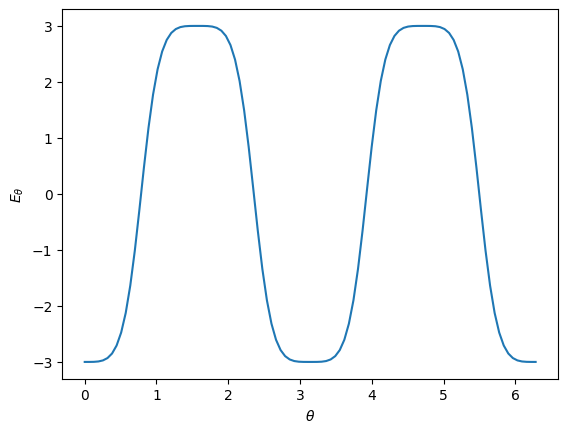

In [13]:
import matplotlib.pyplot as plt

plt.plot(thetas, energies)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$E_\theta$');

### 4. Optimising the energy

Now the goal is to find the optimal value of $\theta$ such that the expectation value of the Hamiltonian is minimized. We will do a gradient based optimization using Jax.

The gradient of a function in Jax can be computed by using the `jax.grad` function, which essentially does the following:

$$
    \text{jax.grad} : f \rightarrow \nabla f
$$

and in our particular case we can do the following:


In [14]:
import jax
from tqdm import tqdm

#argnums=0 determines the index of the arguments w.r.t which the derivative is computed.
# We want the gradient w.r.t the parameters, which is the first argument, so we put 0.
# if we wanted the derivative w.r.t the hamiltonian we would have to put `argnums=1`
energy_derivative = jax.grad(energy, argnums=0)

And now we can try a sample optimisation starting from the initial value of $\theta_0 = 2.$ and updating the angle according to the formula

$$
    \theta_{i+1} = \theta_i - \eta \nabla_\theta E(\theta_i)
$$

where $\nabla$ is the so-called learning rate

In [15]:
#learning rate
nabla = 0.01

#number of steps
n_steps = 100

#initial value for the variational parameter
theta = 2.

#To store the value of the energy and the valiarional paramter during the optimization
energy_history = np.zeros(n_steps)
theta_history = np.zeros(n_steps)
for i in tqdm(range(n_steps)):
    
    # log the variational parameter and the energy
    theta_history[i] = theta
    energy_history[i] = energy(theta, H)
    
    # update the variational parameter according to gradient descent
    theta -= nabla * energy_derivative(theta, H)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 97.73it/s]


And by plotting, we can see that the energy goes down as we continue to apply our algorithm.

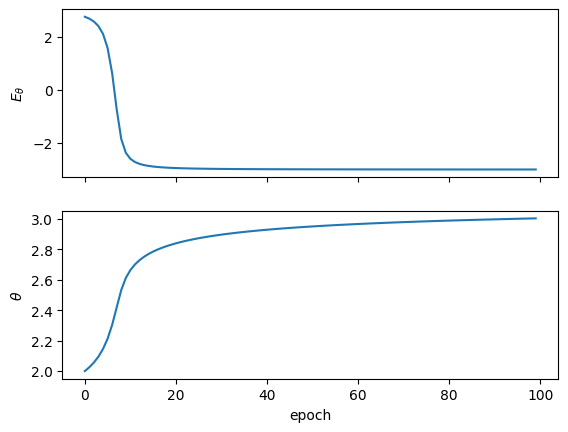

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)

ax1.plot(energy_history)
ax1.set_ylabel(r'$E_\theta$')

ax2.plot(theta_history)
ax2.set_ylabel(r'$\theta$')
ax2.set_xlabel(r'epoch');

### 5. More complex ansatz: 2 parameters

$$
\psi_\theta(\sigma) = \cos\big(\theta_1(1+\sigma)\big) + \exp\big(\theta_2(1-\sigma)\big)
$$

Therefore: 

$$
|\psi_\theta\rangle  := \frac{1}{N} \begin{pmatrix}
                   \cos\big(\theta_1(1+1)\big) + \exp\big(\theta_2(1-1)\big) \\
                   \cos\big(\theta_1(1-1)\big) + \exp\big(\theta_2(1+1)\big)
                       \end{pmatrix} = \frac{1}{N} \begin{pmatrix}\cos\big(2\theta_1\big) + 1 \\
                   1 + \exp\big(2\theta_2\big)
                   \end{pmatrix}                   
$$

In [17]:
import jax.numpy as jnp

def psi(sigma, theta):
    psi = (jnp.cos(theta[0]*(1+sigma))+jnp.exp(theta[1]*(1-sigma))) 
    return psi

def energy(theta, H):
    psi_vec = jnp.array([[psi(1, theta)], [psi(-1, theta)]])
    # note we are normalizing the wave function here!
    psi_vec = psi_vec/jnp.sqrt(jnp.sum(psi_vec**2)) 
        
    return jnp.dot(jnp.transpose(psi_vec), jnp.dot(H, psi_vec))[0,0]

As we wrote the energy function carefully, we can recycle it. Let's explore the energy landscape.

In [18]:
#Let's evaluate the energy as aa function of theta
thetas_1 = np.linspace(0, 2*np.pi, 50)
thetas_2 = np.linspace(-10, 2, 50)
energies = np.empty((50, 50))

for i in range(len(thetas_2)):
    for j in range(len(thetas_1)):
        energies[i, j] = energy(jnp.array([thetas_1[j], thetas_2[i]]), H)

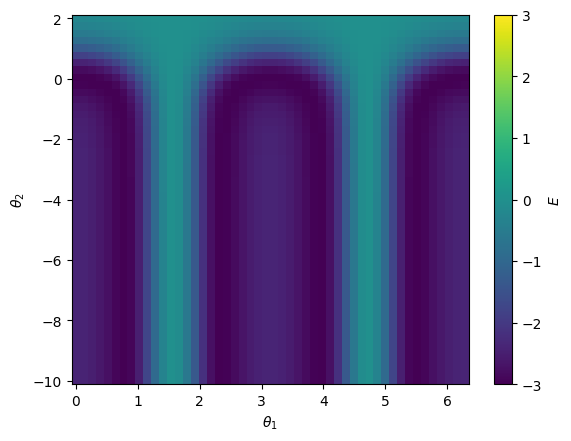

In [19]:
x, y = np.meshgrid(thetas_1, thetas_2)

c = plt.pcolormesh(x, y, energies, cmap = 'viridis', vmax = 3, vmin = -3)

cbar = plt.colorbar(c)
cbar.set_label(r'$E$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');

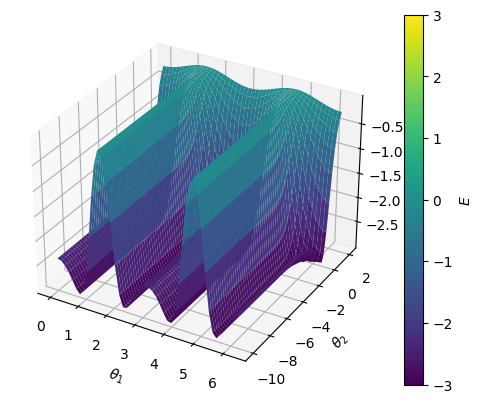

In [20]:
#%matplotlib widget

x, y = np.meshgrid(thetas_1, thetas_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
c = ax.plot_surface(x, y, energies, cmap = 'viridis', vmax = 3, vmin = -3)

cbar = plt.colorbar(c)
cbar.set_label(r'$E$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');

We are even going to recycle the same optimization loop

In [22]:
#compute energy derivative for the new ansatz
energy_derivative = jax.grad(energy, 0) #zero because we only want derivative with respect to 1st positional argument

#learning rate
lr = 0.01

#number of steps
n_steps = 200

#initial value for the variational parameter
theta = jnp.array([1.6, 1.])

#To store the value of the energy and the valiarional paramter during the optimization
energy_history = np.zeros(n_steps)
theta_history = np.zeros((n_steps, 2))
for i in tqdm(range(n_steps)):
    
    #log the variational parameter and the energy
    theta_history[i, :] = theta
    energy_history[i] = energy(theta, H)
    
    #update the variational parameter according to gradient descent
    theta -= lr * energy_derivative(theta, H)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 81.89it/s]


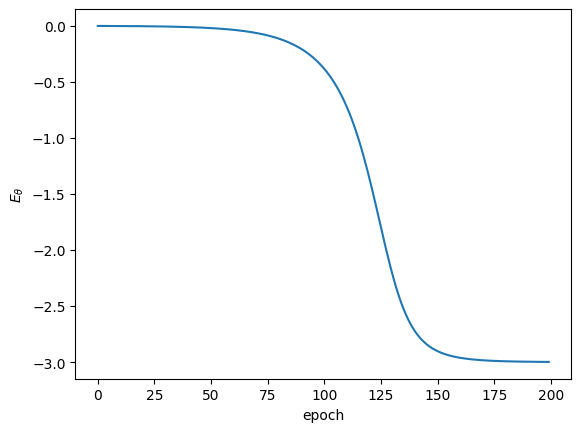

In [23]:
plt.plot(energy_history)
plt.ylabel(r'$E_\theta$')
plt.xlabel(r'epoch');

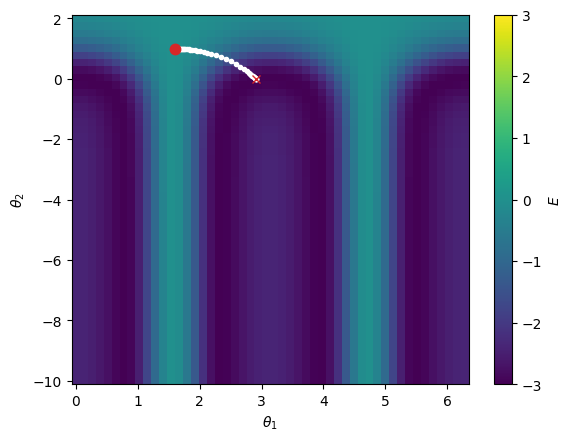

In [24]:
x, y = np.meshgrid(thetas_1, thetas_2)

c = plt.pcolormesh(x, y, energies, cmap = 'viridis', vmax = 3, vmin = -3)
plt.plot(theta_history[::4, 0], theta_history[::4, 1], marker = '.', c = 'w')
plt.plot(theta_history[0, 0], theta_history[0, 1], marker = '.', markersize = 15, c = 'tab:red')
plt.plot(theta_history[-1, 0], theta_history[-1, 1], marker = 'x', c = 'tab:red')

cbar = plt.colorbar(c)
cbar.set_label(r'$E$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');

# 2. Stochastic Reconfiguration (aka, Imaginary Time Evolution or natural Gradient)

### 1.a Vanilla gradient descent update rule:

Let's see how we can obtain the parameter update rule of regular gradient descent: 

$$
\delta \theta_k = -\mu \frac{\partial E_\theta}{\partial \theta_k},
$$

with the goal of understanding the underlying assumptions of that update rule. Remember that $\theta^{(t+1)}_k = \theta^{(t)}_k + \delta \theta_k$.

Consider the loss function $E_\theta$ to be optimized with respect to the set of variational parameters $\{\theta\}$. The goal is to find the set of parameters that extremise $E_\theta$. We know that that happens when $\partial_\theta E_\theta = 0$, or written in terms of infinitesimal increments, when

$$
\Delta E_\theta = E_{\theta+\delta\theta}-E_\theta = \left(E_\theta + \sum_k\frac{\partial E_\theta}{\partial\theta_k}\delta\theta_k + \mathcal{O}\big((\delta \theta)^2\big) \right)- E_\theta = \sum_k\frac{\partial E_\theta}{\partial\theta_k}\delta\theta_k + \mathcal{O}\big((\delta \theta)^2\big)
$$

is equal to $\Delta E_\theta = 0$. Which is the condition of having reached an extremum (modulo saddle points). The other condition that I want to satisfy is that the distance between the new parameters and old parameters is small in parameter space:

$$
d^2 = \sum_k \big(\delta \theta_k \big)^2.
$$

Thus, we can combine the notion that we aim at a null $\Delta E_\theta$ and a very small $d^2$ to obtain an objective function that we want to minimize with respect to the parameter variations $\delta \theta$ (Lagrange Multiplier):

$$
O = \Delta E_\theta + \lambda d^2 = \sum_k\left( \frac{\partial E_\theta}{\partial\theta_k} \delta\theta_k + \lambda (\delta\theta_k)^2\right).
$$

The minimum of that function with respect to $\delta \theta$ is reached when $\frac{\partial O}{\partial (\delta\theta_m)} = 0$:

$$
\frac{\partial }{\partial (\delta\theta_m)} \sum_k\left( \frac{\partial E_\theta}{\partial\theta_k} \delta\theta_k + \lambda (\delta\theta_k)^2\right) = 0 \Rightarrow \sum_k\left( \frac{\partial E_\theta}{\partial \theta_k} + \lambda 2 (\delta\theta_k) \right)\delta_{km} = 0 \Rightarrow \delta \theta_k = -\frac{1}{2\lambda} \frac{\partial E_\theta}{\partial \theta_k}.
$$



### 1.b Natural gradient update rule:

The main idea of natural gradients is to change the notion of distance in parameter space $d^2$ for something that is more "natural" for the problem that one wants to solve. 

In the space of parametrized quantum states, the notion of euclidean distance in parameter space being "small" may not translate well at all to the actual notion of distance in Hilbert spaces (the overlap). Let's do an example:

$$
\psi_\theta(\sigma) = \frac{1}{N}\left( \theta_1 (1+\sigma)/2 + \frac{1}{1+e^{-100(\theta_2-0.9)}}(1-\sigma)/2 \right),
$$

which is ket notation becomes:

$$
|\psi_\theta \rangle := \frac{1}{N} \begin{pmatrix}
                   \theta_1 \\
                   \frac{1}{1+e^{-100(\theta_2-0.9)}}
                   \end{pmatrix}.
$$

If we plot both amplitudes as a function of the respective variational parameters when $\theta\sim 1$:

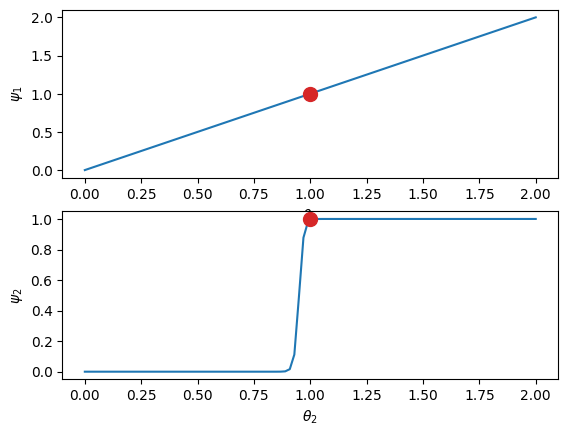

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#define a range of thetas to explore
theta = np.linspace(0, 2, 100)

#compute the amplitudes of the variational wave function
psi_1 = theta+0.
psi_2 = 1/(1+np.exp(-100*(theta-0.95)))

f, (ax1, ax2) = plt.subplots(2, 1, sharex = False)

ax1.plot(theta, psi_1)
ax1.plot([1], [1], marker = '.', markersize = 20, c = 'tab:red')
ax1.set_ylabel(r'$\psi_1$')
ax1.set_xlabel(r'$\theta_1$')

ax2.plot(theta, psi_2)
ax2.plot([1], [1], marker = '.', markersize = 20, c = 'tab:red')
ax2.set_ylabel(r'$\psi_2$')
ax2.set_xlabel(r'$\theta_2$');

In [26]:
import jax.numpy as jnp

#define the amplitudes of the variational state
def psi(theta, sigma):
    #explicitly normalize the state
    N = jnp.sqrt(theta[0]**2 + (1/(1+jnp.exp(-100*(theta[1]-0.95))))**2)
    
    return (theta[0]*(1+sigma)/2. + 1/(1+jnp.exp(-100*(theta[1]-0.95)))*(1-sigma)/2.)/N

#computes the overlap of the trial state for different values of the variational parameter    
def overlap(theta_1, theta_2):
    psi_theta1 = jnp.array([psi(theta_1, 1.), psi(theta_1, -1.)])
    psi_theta2 = jnp.array([psi(theta_2, 1.), psi(theta_2, -1.)])
    
    return jnp.sum(psi_theta1*psi_theta2)


#Let's explore the overlap as we change theta1 and theta2 starting from theta1 = theta2 = 1
theta_init = np.array([1., 1.])
n = 50
delta_theta = np.linspace(0, .2, n)

overlaps = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        theta_m_delta = theta_init-np.array([delta_theta[i], delta_theta[j]])
        overlaps[i, j] = overlap(theta_init, theta_m_delta)


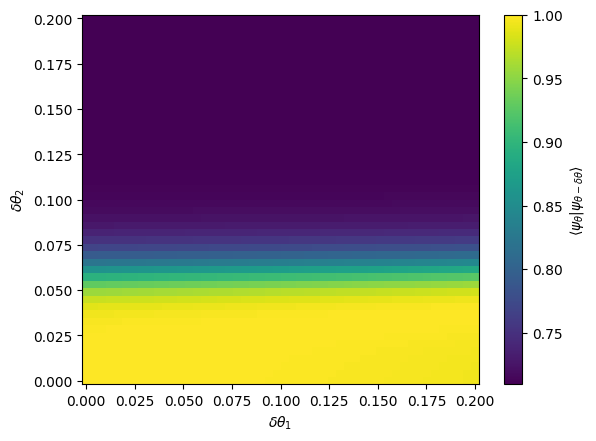

In [27]:
x, y = np.meshgrid(delta_theta, delta_theta)

c = plt.pcolormesh(x, y, overlaps.T, cmap = 'viridis')

cbar = plt.colorbar(c)
cbar.set_label(r'$\langle \psi_\theta|\psi_{\theta-\delta\theta}\rangle$')
plt.xlabel(r'$\delta\theta_1$')
plt.ylabel(r'$\delta\theta_2$');

As we can see, the change of one of the parameters produces a much more abrupt change to the actual wave function than the other one.

**How can we solve this issue?** 

The solution is relatively simple. Change the definition of the metric for the space of parameters (stretches and contracts euclidean space). This is what is called the Fubini-Study metric. Distances are represented by the angle between the vectors that represent the quantum states for parameters $\theta$ and $\theta '$:

$$
d(\psi_\theta, \psi_{\theta '}) = \arccos \left(|\langle \psi_\theta|\psi_{\theta '} \rangle | \right)
$$

Using the good old trick of Taylor expanding things, we can find the infinitesimal squared line element:

$$
d^2(\psi_\theta, \psi_{\theta+\delta\theta}) = \sum_{ij} g_{ij}(\theta) \delta \theta_i \delta \theta_j,
$$

where $g_{ij}(\theta)$ is the metric tensor derived from the Fubini-Study metric:

$$
g_{ij} = \Re \left[ \left \langle \frac{  \partial \psi_\theta}{\partial \theta_i} |\frac{  \partial \psi_\theta}{\partial \theta_j} \right\rangle - \left \langle \frac{ \partial \psi_\theta}{\partial \theta_i} |\psi_\theta \right\rangle \left\langle \psi_\theta| \frac{  \partial \psi_\theta}{\partial \theta_j} \right\rangle  \right].
$$

Now that we have the infinitesimal squared line element, we can find the extremum of the variation of energy and distance in parameter space upon changing the parameters:

$$
O = \Delta E_\theta + \lambda d^2 = \sum_k \frac{\partial E_\theta}{\partial\theta_k} \delta\theta_k + \lambda \sum_{kk'} g_{kk'}(\theta) \delta \theta_k \delta \theta_{k'}.
$$

The minimum of that function with respect to $\delta \theta$ is reached when $\frac{\partial O}{\partial (\delta\theta_m)} = 0$:

$$
\sum_{k'} g_{kk'}(\theta) \delta \theta_{k'} = -\frac{1}{2\lambda} \frac{\partial E_\theta}{\partial \theta_k},
$$

a system of linear equations that we need to solve (numerically). Please note the comparison of the update rule between natural and vanilla gradient descent:

$$
\delta \theta_k = -\frac{1}{2\lambda} \frac{\partial E_\theta}{\partial \theta_k}.
$$

### 1.c visualizing the natural gradient in action:

Let's go back to Monday's single spin example where the Hamiltonian is given by:

$$
H = -B \sigma^x,
$$

and the variational state is given by:

$$
\psi_\theta(\sigma) = \cos\big(\theta_1(1+\sigma)\big) + \exp\big(\theta_2(1-\sigma)\big)
$$

In [28]:
import netket as nk
from netket.operator.spin import sigmax, sigmaz 

#define the Hilbert space for a single spin
N = 1
hi = nk.hilbert.Spin(s=1 / 2, N=N)

#define the Hamiltonian that we saw the other day H = -B \sigma^x
B = 3.
H = -B*sigmax(hi,0) 

In [29]:
#define the model that evaluates the logarithm of the wave function amplitudes

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        theta_1 = self.param(
            "theta_1", nn.initializers.normal(), (1,), float
        )
        
        theta_2 = self.param(
            "theta_2", nn.initializers.normal(), (1,), float
        )
        
        #Remember we have to return the logarithm of the amplitudes and not the amplitudes demeselves!
        return (jnp.log(jnp.cos(theta_1*(1+x))+jnp.exp(theta_2*(1-x)) )).flatten()
    
mf_model = MF()

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi, n_chains=1, n_sweeps=1)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=10000)

#initialize the parameters by hand 
params = vstate.parameters

print (params)

FrozenDict({
    theta_1: Array([0.00442407], dtype=float64),
    theta_2: Array([-0.00767157], dtype=float64),
})


In [30]:
#replicate the dictionary of paramters with the desired set of parameters
init_params = {'theta_1':jnp.array([1.7]), 'theta_2':jnp.array([1.])}

#re-define the parameters atribute of vstate and make sure the update worked
vstate.parameters = init_params
print(vstate.parameters)

#test everything is okay by computing the energy of the initial state
E = vstate.expect(H)
print(type(E))
print(E)

FrozenDict({
    theta_1: Array([1.7], dtype=float64),
    theta_2: Array([1.], dtype=float64),
})
<class 'netket.stats.mc_stats.Stats'>
-1.187e-02 ± 6.783e-19 [σ²=1.204e-35, τ=1.0<1.0]


We are going to do two optimization loops by hand now: one that has the regular gradient descent update rule and one that has the natural gradient update rule.

In [31]:
from tqdm import tqdm
import jax

energy_history_GD = []
param_history_GD = []
n_steps = 100

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    param_history_GD.append([vstate.parameters['theta_1'][0], vstate.parameters['theta_2'][0]])
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history_GD.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_map(lambda x,y: x-0.01*y, vstate.parameters, E_grad)
    # actually update the paramters
    vstate.parameters = new_pars

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.27it/s]


In [32]:
from tqdm import tqdm
import jax

#re-define the parameters atribute of vstate and make sure the update worked
vstate.parameters = init_params
print(vstate.parameters)

energy_history_NG = []
param_history_NG = []
n_steps = 100

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    param_history_NG.append([vstate.parameters['theta_1'][0], vstate.parameters['theta_2'][0]])
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history_NG.append(E.mean.real)
    
    #obatain the quantum geometric tensor from variatioonal state object
    qgt = vstate.quantum_geometric_tensor()
    #the qgt object has a method to solve systems of linear equations
    #of the form qgt*delta_theta = E_grad
    delta_theta, info = qgt.solve(jax.scipy.sparse.linalg.gmres, E_grad)
    
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_map(lambda x,y: x-0.01*y, vstate.parameters, delta_theta)
    # actually update the paramters
    vstate.parameters = new_pars

FrozenDict({
    theta_1: Array([1.7], dtype=float64),
    theta_2: Array([1.], dtype=float64),
})


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 99.43it/s]


Text(0.5, 0, 'epoch')

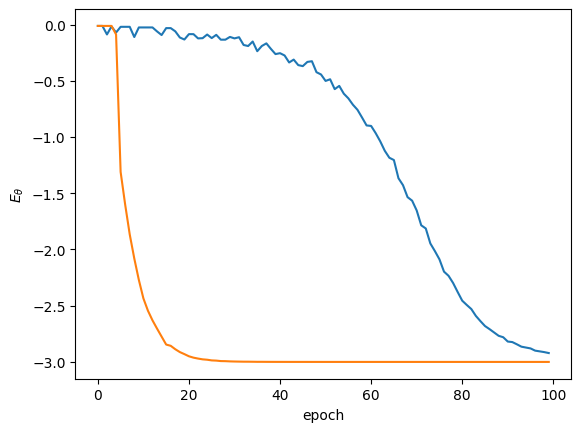

In [33]:
plt.plot(energy_history_GD)
plt.plot(energy_history_NG)
plt.ylabel(r'$E_\theta$')
plt.xlabel(r'epoch')

The fist observation is that the natural gradient converges much faster that vanilla gradient descent, even though the learning rate was the same in both cases. It seems like the natural gradient is not as susceptible to flat regions in the energy landscape. 

Let's take a look at their respective trajectories in parameter space. For that, we will recycle the code from the previous tutorial. I just dumped the necessary functions to evaluate the energy landscape on a grid of parameters in the script ```energy_landscape.py```.

In [34]:
vs_exact = nk.vqs.ExactState(hi, mf_model)

def energy_landscape(thetas_1, thetas_2, H):
    vs_exact = nk.vqs.ExactState(hi, mf_model)

    #Let's evaluate the energy as aa function of theta
    thetas_1 = np.linspace(0, 2*np.pi, 50)
    thetas_2 = np.linspace(-10, 2, 50)
    energies = np.empty((50, 50))

    for i in range(len(thetas_2)):
        for j in range(len(thetas_1)):
            pars = {'theta_1': jnp.array([thetas_1[i]]), 'theta_2':jnp.array([thetas_2[j]])}
            vs_exact.parameters = pars
            energies[i, j] = vs_exact.expect(H).Mean.real

    return energies

In [35]:
thetas_1 = np.linspace(0, 2*np.pi, 50)
thetas_2 = np.linspace(-10, 2, 50)
energies = energy_landscape(thetas_1, thetas_2, H)

#also turn the parameter history lists to arrays
param_history_GD = np.array(param_history_GD)
param_history_NG = np.array(param_history_NG)

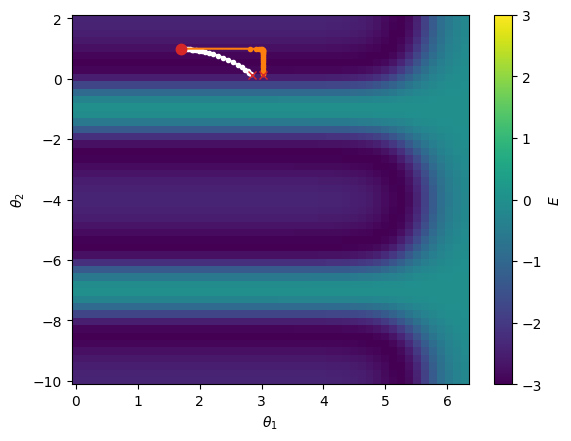

In [36]:
x, y = np.meshgrid(thetas_1, thetas_2)

c = plt.pcolormesh(x, y, energies, cmap = 'viridis', vmax = 3, vmin = -3)
plt.plot(param_history_GD[::4, 0], param_history_GD[::4, 1], marker = '.', c = 'w')
plt.plot(param_history_GD[-1, 0], param_history_GD[-1, 1], marker = 'x', c = 'tab:red')

plt.plot(param_history_NG[::4, 0], param_history_GD[::4, 1], marker = '.', c = 'tab:orange')
plt.plot(param_history_NG[-1, 0], param_history_GD[-1, 1], marker = 'x', c = 'tab:red')
plt.plot(param_history_GD[0, 0], param_history_GD[0, 1], marker = '.', markersize = 15, c = 'tab:red')


cbar = plt.colorbar(c)
cbar.set_label(r'$E$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$');

The natural gradient takes a rather peculiar trajectory in parameter space. In particular, in the first step it performs a large jump in a seemingly arbitrary direction. That is because those two points in parameter space are actually close in wave function space!